<font size="5">Importing Libraries</font>

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import math
import matplotlib.pyplot as plt
import random
import ray

<font size="5">Importing Data</font>

In [2]:
D=sio.loadmat("D:\Study_Docs\EE5907/spamData.mat")
x_train_data=pd.DataFrame(D['Xtrain'])
x_test_data=pd.DataFrame(D['Xtest'])
y_train_data=pd.DataFrame(D['ytrain'])
y_test_data=pd.DataFrame(D['ytest'])

In [3]:
import warnings 
warnings.filterwarnings('ignore')

<font size="5">Data Processing</font>

Logged Transformation

In [4]:
##logarithm of real value + 0.1
logged_data=np.log(x_train_data+0.1)###train data
logged_test_data=np.log(x_test_data+0.1) ## test data

Binarization

In [5]:
binarized_data=x_train_data
binarized_test_data=x_test_data

##train data
###if the value is more than 0.5 then that will assigned with 1, otherwise 0
for j in range(logged_data.shape[1]):
    for i in range(logged_data.shape[0]):
        if(binarized_data.loc[i][j]<=0):
            binarized_data.loc[i][j]=0
        else:
            binarized_data.loc[i][j]=1
##test data
for j in range(logged_test_data.shape[1]):
    for i in range(logged_test_data.shape[0]):
        if(binarized_test_data.loc[i][j]<=0):
            binarized_test_data.loc[i][j]=0
        else:
            binarized_test_data.loc[i][j]=1

<font size='5'>Beta-binomial Naive Bayes  

Feature Selection

In [6]:
spamemail_feature1=[]
spamemail_feature0=[]
nonspammail_feature1=[]
nonspammail_feature0=[]
### according naive bayes formula, we need to calculate (N1+a)/(N+a+b)
###count4 and count6 are the "N1" for spam and non-spam category and when the value of the feature is 1.0
for j in range(binarized_data.shape[1]):
    count4=0
    count5=0
    count6=0
    count7=0
    for i in range(binarized_data.shape[0]):
        if(y_train_data.loc[i][0]==1 and binarized_data.loc[i][j]==1.0):
            count4+=1
        elif(y_train_data.loc[i][0]==1 and binarized_data.loc[i][j]==0.0):
            count5+=1
        elif(y_train_data.loc[i][0]==0 and binarized_data.loc[i][j]==1.0):
            count6+=1
        elif(y_train_data.loc[i][0]==0 and binarized_data.loc[i][j]==0.0):
            count7+=1
    spamemail_feature1.append(count4) ### list of spam N1 for different features when feature value is 1.0
    spamemail_feature0.append(count5)
    nonspammail_feature1.append(count6) ### list of non-spam N1 for different features when feature value is 1.0
    nonspammail_feature0.append(count7)

In [486]:
# spamemail_feature1

<font size="5">prior Probability</font>         

In [7]:
total_spamemails=y_train_data[y_train_data==1].count()[0] ### the true number of spam emails
total_nonspamemails=y_train_data[y_train_data==0].count()[0]  ### true number of non-spam emails
total_emails=y_train_data.shape[0]  ### total number emails we have in our training data set
total_test_spamemails=y_test_data[y_test_data==1].count()[0] ### the true number of spam emails
total_test_nonspamemails=y_test_data[y_test_data==0].count()[0] ### true number of non-spam emails
total_test_emails=y_test_data.shape[0] ### total number emails we have in our test data set

##ML estimate of prior
###(total number of y_train_data belong to each class)/(total number of emails in the training set)
lambda_ML_spam=total_spamemails/total_emails
lambda_ML_nonspam=total_nonspamemails/total_emails

##logged version of Lambda_ML
##(total number of y_test_data belong to each class)/(total number of emails in the test set)
lambda_ML_spam=np.log(lambda_ML_spam)
lambda_ML_nonspam=np.log(lambda_ML_nonspam)

<font size="5">Prediction on training data</font>

In [60]:
##list of different alpha value for beta binomial model. In our case we are
##considering a=b=alpha
## α = {0, 0.5, 1, 1.5, 2, · · · , 100}
i=0
alpha=[]
while(i!=101):
    alpha.append(i)
    i+=0.5

In [61]:
pdf_alpha2=pd.DataFrame(np.zeros([total_emails,len(alpha)])) ##empty dataframe for the spam emails with different alpha value
pdf_alpha3=pd.DataFrame(np.zeros([total_emails,len(alpha)]))  ##empty dataframe for the nonspam emails with different alpha value
for k in range(len(alpha)):
    ##below operation is for calculating (N1+alpha)/(N+2*alpha) on spam class where feature value is 1.0
    data=((np.multiply(binarized_data.transpose(),(pd.DataFrame(spamemail_feature1))).transpose())+alpha[k])/(total_spamemails+2*alpha[k])
    #this prob distribution is for the feature1 of spam class
    pdf_alpha=np.multiply(data,binarized_data)
    ##below operation is for calculating (N1+alpha)/(N+2*alpha) on spam class where feature value is 0.0
    data2=((np.multiply((1-binarized_data.transpose()),(pd.DataFrame(spamemail_feature0))).transpose())+alpha[k])/(total_spamemails+2*alpha[k])
    #this prob distribution is for the feature0 of spam class
    pdf_alpha1=np.multiply((1-binarized_data),data2)
    ##addition of the probabilities of both feature0 and feature1 to make a complete dataframe of probability 
    pdf_spam=pdf_alpha+pdf_alpha1
    ##summation of all the logged probabilities
    a=np.log(pdf_spam).dot(pd.DataFrame(np.ones([binarized_data.shape[1],1])))
    ##below operation is for calculating (N1+alpha)/(N+2*alpha) on non-spam class where feature value is 1.0
    data1=((np.multiply((binarized_data.transpose()),(pd.DataFrame(nonspammail_feature1))).transpose())+alpha[k])/(total_nonspamemails+2*alpha[k])
    #this prob distribution is for the feature1 of non-spam class
    pdf_alpha=np.multiply(data1,binarized_data)
    ##below operation is for calculating (N1+alpha)/(N+2*alpha) on non-spam class where feature value is 0.0
    data3=((np.multiply((1-binarized_data.transpose()),(pd.DataFrame(nonspammail_feature0))).transpose())+alpha[k])/(total_nonspamemails+2*alpha[k])
    #this prob distribution is for the feature0 of non-spam class
    pdf_alpha1=np.multiply((1-binarized_data),data3)
    ##addition of the probabilities of both feature0 and feature1 to make a complete dataframe of probability 
    pdf=pdf_alpha+pdf_alpha1
    ##summation of all the logged probabilities
    b=np.log(pdf).dot(pd.DataFrame(np.ones([binarized_data.shape[1],1])))
    pdf_alpha2.loc[:][k]=a 
    pdf_alpha3.loc[:][k]=b
pdf_alpha2=pdf_alpha2+lambda_ML_spam ##total spam probability = logged(prior probability) + logged(posterior)
pdf_alpha3=pdf_alpha3+lambda_ML_nonspam ## total non-spam probability = logged(prior probability) + logged(posterior)

In [62]:
b=pdf_alpha2.copy()
b[pdf_alpha2>pdf_alpha3]=1
b[pdf_alpha2<pdf_alpha3]=0
y_train_new=pd.DataFrame(y_train_data.values*pd.DataFrame(np.ones([total_emails,len(alpha)])).values)
wrongly_classifiedbin=pd.DataFrame(np.sum(((b!=y_train_new).astype('int')),axis=0)/total_emails*100) ## error in train data

<font size="5" color="blue">Prediction on test data</font>

In [63]:
pdf_test_alpha2=pd.DataFrame(np.zeros([total_test_emails,len(alpha)]))
pdf_test_alpha3=pd.DataFrame(np.zeros([total_test_emails,len(alpha)]))
for k in range(len(alpha)):
    data=((np.multiply(binarized_test_data.transpose(),(pd.DataFrame(spamemail_feature1))).transpose())+alpha[k])/(total_spamemails+2*alpha[k])
    #this prob distribution is for he feature1 of spam class
    pdf_test_alpha=np.multiply(data,binarized_test_data)
    data2=((np.multiply((1-binarized_test_data.transpose()),(pd.DataFrame(spamemail_feature0))).transpose())+alpha[k])/(total_spamemails+2*alpha[k])
    #this prob distribution is for the feature0 of spam class
    pdf_test_alpha1=np.multiply((1-binarized_test_data),data2)
    pdf_test_spam=pdf_test_alpha+pdf_test_alpha1
    a=np.log(pdf_test_spam).dot(pd.DataFrame(np.ones([binarized_test_data.shape[1],1])))
    data1=((np.multiply((binarized_test_data.transpose()),(pd.DataFrame(nonspammail_feature1))).transpose())+alpha[k])/(total_nonspamemails+2*alpha[k])
    pdf_test_alpha=np.multiply(data1,binarized_test_data)
    data3=((np.multiply((1-binarized_test_data.transpose()),(pd.DataFrame(nonspammail_feature0))).transpose())+alpha[k])/(total_nonspamemails+2*alpha[k])
    #this prob distribution is for the feature0 of spam class
    pdf_test_alpha1=np.multiply((1-binarized_test_data),(data3))
    pdf_test=pdf_test_alpha+pdf_test_alpha1
    b=np.log(pdf_test).dot(pd.DataFrame(np.ones([binarized_test_data.shape[1],1])))

    pdf_test_alpha2.loc[:][k]=a
    pdf_test_alpha3.loc[:][k]=b
pdf_test_alpha2=pdf_test_alpha2+lambda_ML_spam
pdf_test_alpha3=pdf_test_alpha3+lambda_ML_nonspam

In [64]:
a=pdf_test_alpha2.copy()##copied version of the spam probability
a[pdf_test_alpha2>pdf_test_alpha3]=1
a[pdf_test_alpha2<pdf_test_alpha3]=0
y_test_new=pd.DataFrame(y_test_data.values*pd.DataFrame(np.ones([total_test_emails,len(alpha)])).values)
wrongly_classifiedtestbin=pd.DataFrame(np.sum(((a!=y_test_new).astype('int')),axis=0)/total_test_emails*100) ## error in test data

<font size="3" color="blue">Plotting the graph inbetween different alpha versus error</font>

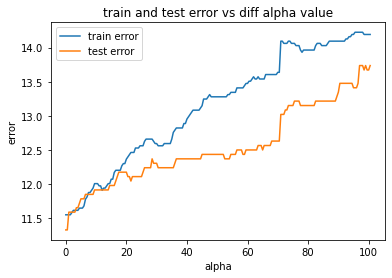

In [65]:
# df = pd.DataFrame({'errors':[alpha], 'val':[wrongly_classified_train,wrongly_classified]})
plt.plot(alpha,np.array(wrongly_classifiedbin), label='train error',color='tab:blue')
plt.plot(alpha,np.array(wrongly_classifiedtestbin), label='test error',color='tab:orange')
plt.title('train and test error vs diff alpha value')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('error')
plt.show()

<font size="5">Logistic Regression</font>

In [86]:
m=pd.DataFrame(np.ones([total_emails,1]))
n=pd.concat([m,logged_data],axis=1,ignore_index=True) ##introducing the bias column in the dataset
w=pd.DataFrame(np.zeros([logged_data.shape[1]+1,1])) ## considering the bias weight

In [87]:
m_test=pd.DataFrame(np.ones([total_test_emails,1])) 
n_test=pd.concat([m_test,logged_test_data],axis=1,ignore_index=True) ##introducing the bias column in the test dataset

In [88]:
##LIST OF DIFFERENT LAMBDA VALUES λ = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100}
lam=[]
for i in range(1,10):
    lam.append(i)
for j in range(10,101,5):
    lam.append(j)

train prediction

In [90]:
y_pred_lam=pd.DataFrame(np.zeros([total_emails,len(lam)]))
Nll=pd.DataFrame(np.zeros([1,len(lam)]))
w_con=pd.DataFrame(np.zeros([n.shape[1],len(lam)]))
for k in range(len(lam)):
    Neglog_new=0
    Neglog_prev=1
    while(Neglog_prev!=Neglog_new): ## untill negative logarithimic value converges or becomes stable
        Neglog_prev=Neglog_new ## the newly calculated nll value will be assigned to the previous nll value
        y_pred=1/(1+np.exp(-(n*w.transpose().values).dot(np.ones([58,1])))) ## sigmoid function
        
        Neglog_reg=np.sum(y_train_data.multiply(np.log(y_pred))+(1-y_train_data).multiply(np.log(1-y_pred)),axis=0)+\
        0.5*lam[k]*(w.transpose().dot(w))  ## nll=y(log(mu))+(1-y)(log(1-mu))
        Neglog_new=Neglog_reg.loc[0][0]
        g=pd.DataFrame(np.dot((n.transpose()),(y_pred-y_train_data))) ## gradient calculation
        w_g=pd.DataFrame(np.vstack((0,w.loc[1:][:]))) ##padding in first column
        g_reg=g+lam[k]*w_g  ##regularization of gradient
        
        s=y_pred*(1-y_pred) ## diagonal matrix
#         zeros=pd.DataFrame([3065,3065])
        S=pd.DataFrame(np.diag(np.matrix(s).A1)) ##putting all the S value in the diagonals
        
        h=(n.transpose()).dot(S.dot(n)) ##hessian calculation 
        w_h=pd.DataFrame(np.vstack((np.zeros([1,58]),np.hstack((np.zeros([57,1]),np.eye(57))))))
        h_reg=h+lam[k]*w_h ## regularization of hessian 
        h_inv=pd.DataFrame(np.linalg.inv(h_reg.values)) 
        
        w=w-h_inv.dot(g_reg) ## w_new=w_old - inv(h)*g
    w_con[:][k]=w
    y_pred_lam[:][k]=y_pred
    Nll[:][k]=Neglog_reg

 train error

In [91]:
y_pred=y_pred_lam.copy()
y_pred[y_pred>0.5]=1
y_pred[y_pred<0.5]=0
y_train_new=pd.DataFrame(y_train_data.values*pd.DataFrame(np.ones([total_emails,28])).values)
wrongly_classifiedlog=np.sum(((y_pred!=y_train_new).astype('int')),axis=0)/total_emails*100 ##train error

 test prediction and test error

In [92]:
y_pred_test=1/(1+np.exp(-np.dot(n_test,w_con)))
y_predtest=pd.DataFrame(np.zeros([total_test_emails,28]))
y_data=pd.DataFrame(y_pred_test)
y_data[y_data>0.5]=1
y_data[y_data<0.5]=0
y_test_new=pd.DataFrame(y_test_data.values*pd.DataFrame(np.ones([total_test_emails,28])).values)
wrongly_classifiedtestlog=np.sum(((y_data!=y_test_new).astype('int')),axis=0)/total_test_emails*100 ## test error

<font size="4">Plotting</font>

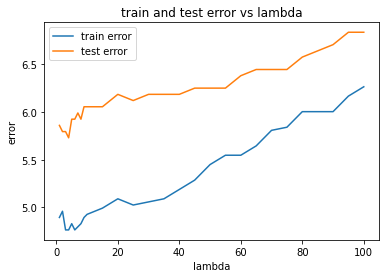

In [93]:
plt.plot(lam,np.array(wrongly_classifiedlog),label='train error', color='tab:blue')
plt.plot(lam,np.array(wrongly_classifiedtestlog), label='test error', color='tab:orange')
plt.title('train and test error vs lambda')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('error')
plt.show()

<font size="5">Gaussian</font>

In [77]:
###Data processing and estimation of Mean and Variance
spam=logged_data.copy()
non_spam=logged_data.copy()

## below operation is to take create two separate matrix of spam and non_spam data to 
## do further operations in matrix form only
for i in range(logged_data.shape[0]):
    if(y_train_data.loc[i][0]==1):
        spam.loc[i][:]=1
        non_spam.loc[i][:]=0
    else:
        spam.loc[i][:]=0
        non_spam.loc[i][:]=1

spam_data=spam.multiply(logged_data) ##all the logged spam data matrix
non_spam_data=non_spam.multiply(logged_data) ##all the logged non_spam data matrix
ones=np.ones([total_emails,1])
##calculation of mean for each feature on spam matrix
mean_spam=(spam_data.transpose().dot(ones))/total_spamemails 
##calculation of mean for each feature on nonspam matrix
mean_nonspam=(non_spam_data.transpose().dot(ones))/total_nonspamemails 
#calculation of variance for each feature on spam matrix
var_spam=(((spam_data.subtract(np.multiply(spam,(pd.DataFrame(np.ones([57,3065]))*mean_spam.values).transpose())))**2).transpose().dot(ones))/total_spamemails
#calculation of variance for each feature on non-spam matrix
var_nonspam=(((non_spam_data.subtract(np.multiply(non_spam,(pd.DataFrame(np.ones([57,3065]))*mean_nonspam.values).transpose())))**2).transpose().dot(ones))/total_nonspamemails

test prediction

In [78]:
##calculating probability of getting spam class on training data
const_spam=1/np.multiply(math.sqrt(2*math.pi),var_spam**0.5)

pdf_spam=np.log((np.exp(((logged_data.subtract((pd.DataFrame(np.ones([57,3065]))*mean_spam.values).transpose()))**2)*
                   (-0.5)/(pd.DataFrame(np.ones([57,3065]))*var_spam.values).transpose())*
            (pd.DataFrame(np.ones([57,3065]))*const_spam.values).transpose()))
total_pdf_spam=pdf_spam.dot(pd.DataFrame(np.ones([57,1])))+lambda_ML_spam
## calculating probability of getting non-spam class on training data
const_nonspam=1/np.multiply(math.sqrt(2*math.pi),var_nonspam**0.5)
pdf_nonspam=np.log((np.exp(((logged_data.subtract((pd.DataFrame(np.ones([57,3065]))*mean_nonspam.values).transpose()))**2)*
                   (-0.5)/(pd.DataFrame(np.ones([57,3065]))*var_nonspam.values).transpose())*
            (pd.DataFrame(np.ones([57,3065]))*const_nonspam.values).transpose()))
total_pdf_nonspam=pdf_nonspam.dot(pd.DataFrame(np.ones([57,1])))+lambda_ML_nonspam

test prediction

In [79]:
##calculating probability of getting spam class on test data
const_spam=1/np.multiply(math.sqrt(2*math.pi),var_spam**0.5)
pdf_spamtest=np.log((np.exp(((logged_test_data.subtract((pd.DataFrame(np.ones([57,total_test_emails]))*mean_spam.values).transpose()))**2)*\
                   (-0.5)/(pd.DataFrame(np.ones([57,total_test_emails]))*var_spam.values).transpose())*\
            (pd.DataFrame(np.ones([57,total_test_emails]))*const_spam.values).transpose()))
totaltest_pdf_spam=pdf_spamtest.dot(pd.DataFrame(np.ones([57,1])))+lambda_ML_spam
## calculating probability of getting non-spam class on test data
const_nonspam=1/np.multiply(math.sqrt(2*math.pi),var_nonspam**0.5)
pdf_nonspamtest=np.log((np.exp(((logged_test_data.subtract((pd.DataFrame(np.ones([57,total_test_emails]))*mean_nonspam.values).transpose()))**2)*
                   (-0.5)/(pd.DataFrame(np.ones([57,total_test_emails]))*var_nonspam.values).transpose())*
            (pd.DataFrame(np.ones([57,total_test_emails]))*const_nonspam.values).transpose()))
totaltest_pdf_nonspam=pdf_nonspamtest.dot(pd.DataFrame(np.ones([57,1])))+lambda_ML_nonspam

  train error

In [80]:
arb=total_pdf_spam.copy()
arb[total_pdf_spam>total_pdf_nonspam]=1
arb[total_pdf_spam<total_pdf_nonspam]=0
wrongly_classifiedgau=(np.sum(((arb!=y_train_data).astype('int')),axis=0)/total_emails*100).squeeze(0)##train error

  test error

In [81]:
arb_test=totaltest_pdf_spam.copy()
arb_test[totaltest_pdf_spam>totaltest_pdf_nonspam]=1
arb_test[totaltest_pdf_spam<totaltest_pdf_nonspam]=0
count_test=0
wrongly_classifiedtestgau=(np.sum(((arb_test!=y_test_data).astype('int')),axis=0)/total_test_emails*100).squeeze(0) ##test error

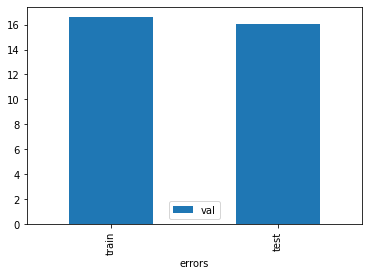

In [82]:
df = pd.DataFrame({'errors':['train','test'], 'val':[wrongly_classifiedgau,wrongly_classifiedtestgau]})
ax=df.plot.bar(x='errors',y='val')

In [84]:
wrongly_classifiedtestgau

16.015625

<font size='5'>KNN

In [103]:
##LIST OF DIFFERENT k VALUES k = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100}
k=[]
for i in range(1,10):
    k.append(i)
for j in range(10,101,5):
    k.append(j)

  
train prediction

In [104]:
y_pred_train=pd.DataFrame(np.zeros([3065,28]))
for m in range(len(k)):
    for l in range(logged_data.shape[0]): ## prediction of class for each email
        ## for each lth train email the distance from other emails for each feature are calculated and 
        ### the distances of each features are getting added for each email
        value=(pd.DataFrame(np.sum((logged_data-logged_data.loc[l][:])**2,axis=1),columns=['0'])**0.5).drop([l])
        
        value=value.sort_values(by=['0'])##sorting the distances based on dataframe value. so the indices remain same as before

        neighbors=value.head(k[m]) ## taking k nearest emails
        a=y_train_data.loc[neighbors.index][y_train_data==0].count()[0] ## number of non-spam emails among the k nearest emails
        b=y_train_data.loc[neighbors.index][y_train_data==1].count()[0] ## number of spam emails among the k nearest emails
        if((a/k[m])==(b/k[m])): ## incase of a tie
            y_pred_train.loc[l][m]=0
        if((a/k[m])>(b/k[m])): ## incase the probability of non-spam is getter than spam
            y_pred_train.loc[l][m]=0
        else:
            y_pred_train.loc[l][m]=1


train error

In [105]:
y_train_new=pd.DataFrame(y_train_data.values*pd.DataFrame(np.ones([total_emails,28])).values)
f=y_pred_train.astype('int')
wrongly_classifiedknn=np.sum(((f!=y_train_new).astype('int')),axis=0)/total_emails*100

test prediction   

In [106]:
y_test_pred=pd.DataFrame(np.zeros([1536,28]))
for m in range(len(k)):
    for l in range(logged_test_data.shape[0]):## prediction of class for each email
        ## for each lth test email the distance from other emails for each feature are calculated and 
        ### the distances of each features are getting added for each email
        value=(pd.DataFrame(np.sum((logged_data-logged_test_data.loc[l][:])**2,axis=1),columns=['0'])**0.5)
        value=value.sort_values(by=['0'])

        neighbors=value.head(k[m])
        a=y_train_data.loc[neighbors.index][y_train_data==0].count()[0]
        b=y_train_data.loc[neighbors.index][y_train_data==1].count()[0]
        if((a/k[m])==(b/k[m])):
            y_test_pred.loc[l][m]=0
        if((a/k[m])>(b/k[m])):
            y_test_pred.loc[l][m]=0
        else:
            y_test_pred.loc[l][m]=1

test error

In [107]:
y_test_new=pd.DataFrame(y_test_data.values*pd.DataFrame(np.ones([total_test_emails,28])).values)
f=y_test_pred.astype('int')
wrongly_classifiedtestknn=np.sum(((f!=y_test_new).astype('int')),axis=0)/total_test_emails*100

Plotting   

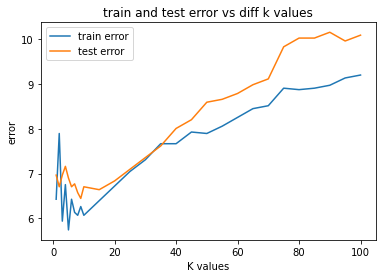

In [108]:
plt.plot(k,wrongly_classifiedknn,label='train error',color='tab:blue',)
plt.plot(k,wrongly_classifiedtestknn, label='test error',color='tab:orange')
# plt.label('train','test')
plt.title('train and test error vs diff k values')
plt.legend(loc='upper left')
plt.xlabel('K values')
plt.ylabel('error')
plt.show()
